# General imports

In [1]:

from tqdm import tqdm
import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib notebook

# PyHEADTAIL imports

In [2]:


from LHC import LHC
from PyHEADTAIL.impedances.wakes import WakeTable, WakeField
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.particles.slicing import UniformChargeSlicer

PyHEADTAIL v1.16.0


# Numerical parameters

In [4]:
# Basic parameters.
n_turns = 1000
n_macroparticles = 1e6

# Machine parameters

In [7]:
Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443

C = 26658.883
R = C / (2.*np.pi)

alpha_x = 0.
alpha_y = 0.
beta_x = 66.0064
beta_y = 71.5376
alpha_0 = [0.0003225]

machine_configuration = 'LHC_6.5TeV_collision_2016'

chroma = 0
i_oct = 0

def get_nonlinear_params(chroma, i_oct, p0=6.5e12*e/c):
    '''Arguments:
        - chroma: first-order chromaticity Q'_{x,y}, identical
          for both transverse planes
        - i_oct: octupole current in A (positive i_oct means
          LOF = i_oct > 0 and LOD = -i_oct < 0)
    '''
    # factor 2p0 is PyHEADTAIL's convention for d/dJx instead of
    # MAD-X's convention of d/d(2Jx)
    app_x = 2 * p0 * 27380.10941 * i_oct / 100.
    app_y = 2 * p0 * 28875.03442 * i_oct / 100.
    app_xy = 2 * p0 * -21766.48714 * i_oct / 100.
    Qpp_x = 4889.00298 * i_oct / 100.
    Qpp_y = -2323.147896 * i_oct / 100.
    return {
        'app_x': app_x,
        'app_y': app_y,
        'app_xy': app_xy,
        'Qp_x': [chroma,],# Qpp_x],
        'Qp_y': [chroma,],# Qpp_y],
        # second-order chroma commented out above!
    }

machine = LHC(n_segments=1,
              machine_configuration=machine_configuration,
              **get_nonlinear_params(chroma=chroma, i_oct=i_oct))

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]


# Beam Parameters

In [17]:
epsn_x = 3.e-6 # normalised horizontal emittance
epsn_y = 3.e-6 # normalised vertical emittance
sigma_z = 1.2e-9 * machine.beta*c/4. # RMS bunch length in meters
intensity = 1.1e11

bunch = machine.generate_6D_Gaussian_bunch_matched(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770313589648
--> Emittance: 2.3327935372128716


# Import Wake

In [18]:
slicer_for_wakefields = UniformChargeSlicer(
        1000, z_cuts=(-3*sigma_z, 3*sigma_z))

wakefile = 'wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2021_TeleIndex1_updatedMOs_updatedMo_on_MoC_wake'

data_wake = np.genfromtxt(wakefile + '.dat')
data_wake_noquad = data_wake[:,[0,1,2]]

np.savetxt(wakefile+"_no_quad.dat", data_wake_noquad, delimiter='\t', fmt='%15.10e' ,newline='\n')

wake_table = WakeTable(wakefile+"_no_quad.dat",
                        ['time', 'dipole_x', 'dipole_y',
                          # 'quadrupole_x', 'quadrupole_y',
                         #'dipole_xy', 'dipole_yx',
                        ])
wake_field = WakeField(slicer_for_wakefields, wake_table)

dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.


# Create Damper

In [19]:
damping_rate = 100 # in turns

# create transverse feedback instance
damper = TransverseDamper(damping_rate, damping_rate)

Dampers active


# Create one-turn map

In [20]:
machine.one_turn_map.append(damper)
machine.one_turn_map.append(wake_field)

# Do the tracking

In [21]:
# prepare empty arrays to record transverse moments
x = np.empty(n_turns, dtype=float)
xp = np.empty_like(x)
y = np.empty_like(x)
yp = np.empty_like(x)

# actual tracking
t = np.arange(n_turns)
for i in t:
    for m in machine.one_turn_map:
        m.track(bunch)
        x[i] = bunch.mean_x()
        xp[i] = bunch.mean_xp()
        y[i] = bunch.mean_y()
        yp[i] = bunch.mean_yp()

In [22]:
# evaluation of dipolar bunch moments
j_x = np.sqrt(x**2 + (beta_x * xp)**2)
exponent_x, amplitude_x = np.polyfit(t, np.log(2 * j_x), 1)

j_y = np.sqrt(y**2 + (beta_y * yp)**2)
exponent_y, amplitude_y = np.polyfit(t, np.log(2 * j_y), 1)

print ('Horizontal reconstructed damping time: {:.3f} turns'.format(1/exponent_x))
print ('Vertical reconstructed damping time: {:.3f} turns'.format(1/exponent_y))

Horizontal reconstructed damping time: -616.502 turns
Vertical reconstructed damping time: -383.417 turns


<IPython.core.display.Javascript object>


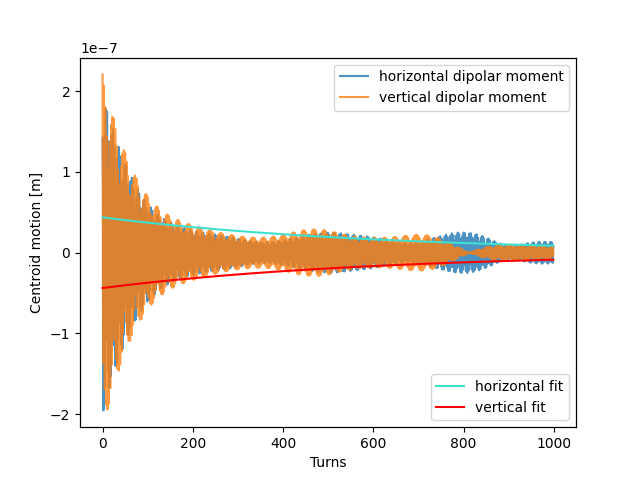

In [23]:
plt.plot(t, x, label='horizontal dipolar moment', alpha=0.8)
plt.plot(t, y, label='vertical dipolar moment', alpha=0.8)
ylim = plt.ylim()
plt.legend(loc=0);
plt.xlabel('Turns')
plt.ylabel('Centroid motion [m]')
plt.twinx()
plt.plot(t, np.exp(amplitude_x + (exponent_x*t)) / 2., color='turquoise', label='horizontal fit')
plt.plot(t, -np.exp(amplitude_x + (exponent_x*t)) / 2., color='red', label='vertical fit')
plt.ylim(ylim)
plt.legend(loc=4)
plt.yticks([]);

# Without quadrupolar impedance

## Import Wake

In [21]:

from tqdm import tqdm
import numpy as np
np.random.seed(42)

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib notebook

from LHC import LHC
from PyHEADTAIL.impedances.wakes import WakeTable, WakeField
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.particles.slicing import UniformChargeSlicer

Q_x = 64.28
Q_y = 59.31
Q_s = 0.0020443
n_turns = 5000


def py_ht_wake_sim(n_macroparticles, n_slices, components_wake_input=None, add_wake=True, add_damper=True):
    

    C = 26658.883
    R = C / (2.*np.pi)

    alpha_x = 0.
    alpha_y = 0.
    beta_x = 66.0064
    beta_y = 71.5376
    alpha_0 = [0.0003225]

    machine_configuration = 'LHC_6.5TeV_collision_2016'

    chroma = 0
    i_oct = 0

    def get_nonlinear_params(chroma, i_oct, p0=6.5e12*e/c):
        '''Arguments:
            - chroma: first-order chromaticity Q'_{x,y}, identical
              for both transverse planes
            - i_oct: octupole current in A (positive i_oct means
              LOF = i_oct > 0 and LOD = -i_oct < 0)
        '''
        # factor 2p0 is PyHEADTAIL's convention for d/dJx instead of
        # MAD-X's convention of d/d(2Jx)
        app_x = 2 * p0 * 27380.10941 * i_oct / 100.
        app_y = 2 * p0 * 28875.03442 * i_oct / 100.
        app_xy = 2 * p0 * -21766.48714 * i_oct / 100.
        Qpp_x = 4889.00298 * i_oct / 100.
        Qpp_y = -2323.147896 * i_oct / 100.
        return {
            'app_x': app_x,
            'app_y': app_y,
            'app_xy': app_xy,
            'Qp_x': [chroma,],# Qpp_x],
            'Qp_y': [chroma,],# Qpp_y],
            # second-order chroma commented out above!
        }
    
    machine = LHC(n_segments=1,
                  machine_configuration=machine_configuration,
                  **get_nonlinear_params(chroma=chroma, i_oct=i_oct))

    
    epsn_x = 3.e-6 # normalised horizontal emittance
    epsn_y = 3.e-6 # normalised vertical emittance
    sigma_z = 1.2e-9 * machine.beta*c/4. # RMS bunch length in meters
    intensity = 1.1e11

    bunch = machine.generate_6D_Gaussian_bunch_matched(
            n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

    slicer_for_wakefields = UniformChargeSlicer(
            n_slices, z_cuts=(-8*sigma_z, 8*sigma_z))

    wakefile = 'wakeforhdtl_PyZbase_Allthemachine_6800GeV_B1_2021_TeleIndex1_updatedMOs_updatedMo_on_MoC_wake'

    data_wake = np.genfromtxt(wakefile + '.dat')
    
    components_wake = ['time', 'dipole_x', 'dipole_y',
                       'quadrupole_x', 'quadrupole_y',
                       'dipole_xy', 'dipole_yx']
    
    if components_wake_input is None: 
        components_wake_input = components_wake.copy()
    
    inds_wake = [0]
    
    for i, comp_inp in enumerate(components_wake_input):
            for comp in components_wake:
                if comp_inp == comp:
                    inds_wake.append(i)
                
                
    data_wake = data_wake[:,inds_wake]
    components_wake = np.array(components_wake)[inds_wake]
    
    np.savetxt(wakefile+"_user.dat", data_wake, delimiter='\t', fmt='%15.10e' ,newline='\n')

    wake_table = WakeTable(wakefile+"_no_quad.dat",
                            ['time', 'dipole_x', 'dipole_y',
                             #'quadrupole_x', 'quadrupole_y',
                             #'dipole_xy', 'dipole_yx',
                            ])

    os.system('rm '+wakefile+ '_user.dat')
    
    wake_field = WakeField(slicer_for_wakefields, wake_table)

    damping_rate = 1000 # in turns

    # create transverse feedback instance
    damper = TransverseDamper(damping_rate, damping_rate)
    bunch.xp -= bunch.mean_xp()
    bunch.yp -= bunch.mean_yp()
    bunch.x -= bunch.mean_x() - 1e-4
    bunch.y -= bunch.mean_y() - 1e-4
    
    if add_damper:
        machine.one_turn_map.append(damper)
    if add_wake:
        machine.one_turn_map.append(wake_field)

    # prepare empty arrays to record transverse moments
    x = np.empty(n_turns, dtype=float)
    xp = np.empty_like(x)
    y = np.empty_like(x)
    yp = np.empty_like(x)

    # actual tracking
    t = np.arange(n_turns)
    for i in tqdm(t):
        for m in machine.one_turn_map:
            m.track(bunch)
            x[i] = bunch.mean_x()
            xp[i] = bunch.mean_xp()
            y[i] = bunch.mean_y()
            yp[i] = bunch.mean_yp()

    # evaluation of dipolar bunch moments
    j_x = np.sqrt(x**2 + (beta_x * xp)**2)
    exponent_x, amplitude_x = np.polyfit(t, np.log(2 * j_x), 1)

    j_y = np.sqrt(y**2 + (beta_y * yp)**2)
    exponent_y, amplitude_y = np.polyfit(t, np.log(2 * j_y), 1)

    print ('Horizontal reconstructed damping time: {:.3f} turns'.format(1/exponent_x))
    print ('Vertical reconstructed damping time: {:.3f} turns'.format(1/exponent_y))

    plt.figure()
    plt.plot(t, x, label='horizontal dipolar moment', alpha=0.8)
    plt.plot(t, y, label='vertical dipolar moment', alpha=0.8)
    ylim = plt.ylim()
    plt.legend(loc=0);
    plt.xlabel('Turns')
    plt.ylabel('Centroid motion [m]')
    plt.twinx()
    plt.plot(t, np.exp(amplitude_x + (exponent_x*t)) / 2., color='turquoise', label='horizontal fit')
    plt.plot(t, -np.exp(amplitude_x + (exponent_x*t)) / 2., color='red', label='vertical fit')
    plt.title('N_mp: ' + str(n_macroparticles) +' N_sl: ' + str(n_slices))
    plt.ylim(ylim)
    plt.legend(loc=4)
    plt.yticks([]);
    
    return x, y, xp, yp, machine

In [23]:
import sys, os

sys.path.append('/home/giacomel/PyCOMPLETE')
from PySUSSIX import Sussix

def calc_sussix_spec(x, xp, y, yp, q_x, q_y, n_lines=1):
    # Initialise Sussix object
    SX = Sussix()
    SX.sussix_inp(nt1=1, nt2=len(x), idam=2, ir=0, tunex=q_x, tuney=q_y)

    SX.sussix(x, xp,
              y, yp,
              # this line is not used by sussix:
              x, xp)

    os.remove('sussix.inp')

    return SX.ox[:n_lines], SX.oy[:n_lines]

def compute_tune_windows(x, xp, y, yp, machine):
    spec_x, spec_y = calc_sussix_spec(x, xp, y, yp, machine.Q_x%1, machine.Q_y%1)
    print ('Horizontal fractional tune: {:.3f} vs. reconstructed {:.3f}'.format(machine.Q_x%1, spec_x[0]))
    print ('Vertical fractional tune: {:.3f} vs. reconstructed {:.3f}'.format(machine.Q_y%1, spec_y[0]))

    Q_window_size = 200
    window_staggering = 20
    n_int = 0
    Qx = []
    Qy = []
    n_turns_max=5000
    while n_int*window_staggering+Q_window_size<n_turns_max:
        n_init = n_int*window_staggering
        n_end = n_int*window_staggering+Q_window_size
        spec_x, spec_y = calc_sussix_spec(x[n_init:n_end], xp[n_init:n_end], y[n_init:n_end], yp[n_init:n_end], machine.Q_x%1, machine.Q_y%1)
        Qx.append(spec_x)
        Qy.append(spec_y)
        n_int+=1

    plt.figure()
    plt.plot(np.ones_like(Qx)*(machine.Q_x%1), 'r--', label='Machine Qx')
    plt.plot(Qx, 'r', label='Measured Qx')
    plt.plot(np.ones_like(Qy)*(machine.Q_y%1), 'b--', label='Machine Qy')
    plt.plot(Qy, 'b', label='Measured Qy')
    plt.legend()

# No Wake - No Damper

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770313589648
--> Emittance: 2.3327935372128716
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
Dampers active


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6909.74it/s]

Horizontal reconstructed damping time: 26802229.348 turns
Vertical reconstructed damping time: 33726994.205 turns


<IPython.core.display.Javascript object>


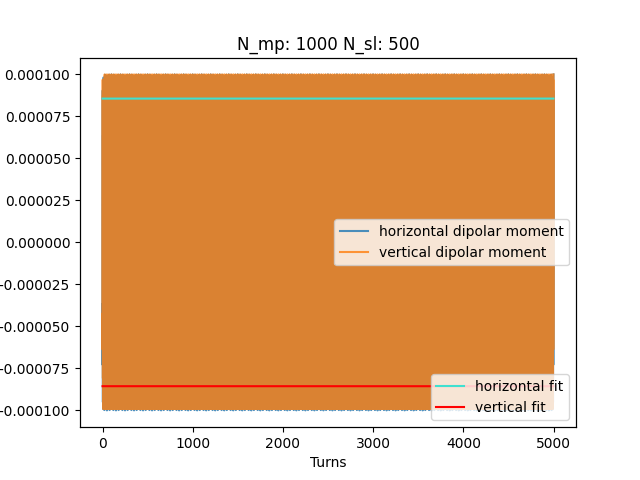

In [25]:
# Basic parameters.
n_sl = 500
n_mps = 1000000

x, y, xp, yp, machine = py_ht_wake_sim(n_mps, n_sl, add_damper=False, add_wake=False)

Horizontal fractional tune: 0.310 vs. reconstructed 0.310
Vertical fractional tune: 0.320 vs. reconstructed 0.320


<IPython.core.display.Javascript object>


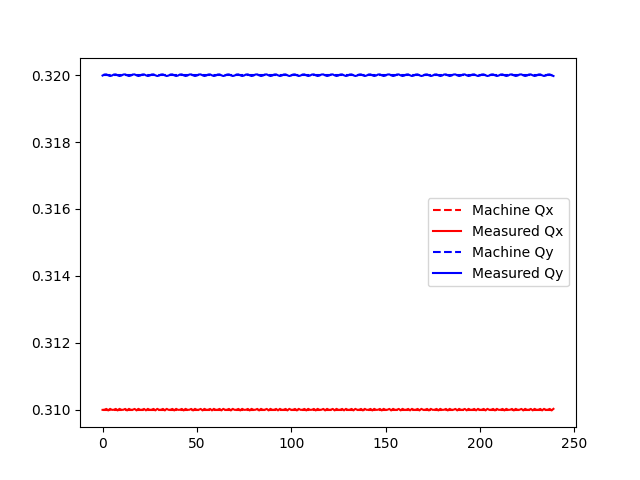

In [26]:
compute_tune_windows(x, xp, y, yp, machine)

# Damper - No Wake

In [ ]:
# Basic parameters.
n_sl = 500
n_mps = 1000000

x, y, xp, yp, machine = py_ht_wake_sim(n_mps, n_sl, add_damper=True, add_wake=False)

In [ ]:
compute_tune_windows(x, xp, y, yp, machine)

# Damper - Dipolar Wake

In [ ]:
# Basic parameters.
n_sl = 500
n_mps = 1000000

x, y, xp, yp, machine = py_ht_wake_sim(n_mps, n_sl, add_damper=True, add_wake=True, 
                                       components_wake_input=['time', 'dipole_x', 'dipole_y'])

In [ ]:
compute_tune_windows(x, xp, y, yp, machine)

# Complete Wake

Synchrotron init. From kwargs: app_x = 0.0
Synchrotron init. From kwargs: app_y = 0.0
Synchrotron init. From kwargs: app_xy = -0.0
Synchrotron init. From kwargs: Qp_x = [0 ...]
Synchrotron init. From kwargs: Qp_y = [0 ...]
*** Maximum RMS bunch length 0.11789515101464539m.
... distance to target bunch length: -8.9938e-02
... distance to target bunch length: 2.4700e-02
... distance to target bunch length: 2.2562e-02
... distance to target bunch length: 4.1287e-03
... distance to target bunch length: -8.3050e-03
... distance to target bunch length: 6.8811e-04
... distance to target bunch length: -1.6257e-05
... distance to target bunch length: 2.5724e-07
... distance to target bunch length: -3.3327e-08
--> Bunch length: 0.08993770313589648
--> Emittance: 2.3327935372128716
dipole_x Assuming ultrarelativistic wake.
dipole_y Assuming ultrarelativistic wake.
Dampers active


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [16:42<00:00,  4.99it/s]

Horizontal reconstructed damping time: -1196.011 turns
Vertical reconstructed damping time: -1236.734 turns


<IPython.core.display.Javascript object>


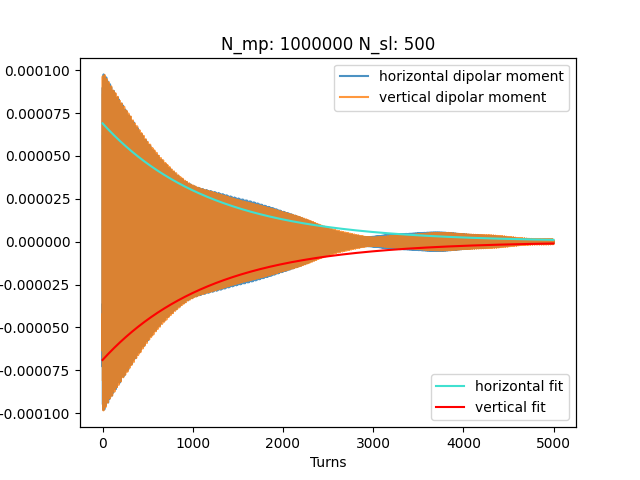

In [15]:
# Basic parameters.
#n_mp_p_sl = 500
n_sl = 500
n_mps = 1000000

#n_mp_p_sl = 500
x, y, xp, yp, machine = py_ht_wake_sim(n_mps, n_sl, add_damper=True, add_wake=True)

Horizontal fractional tune: 0.310 vs. reconstructed 0.309
Vertical fractional tune: 0.320 vs. reconstructed 0.319


<IPython.core.display.Javascript object>


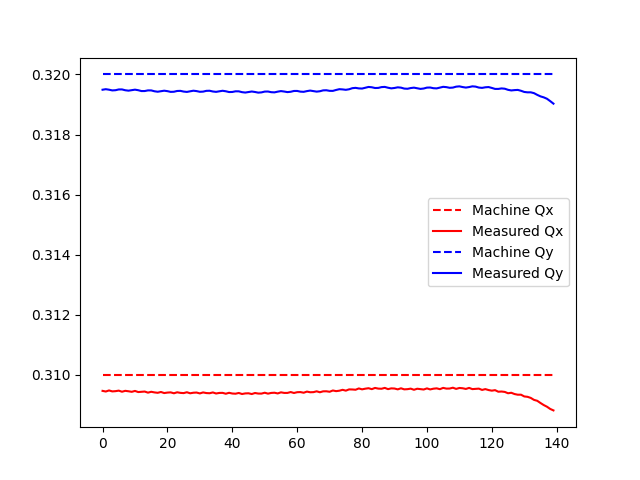

<IPython.core.display.Javascript object>


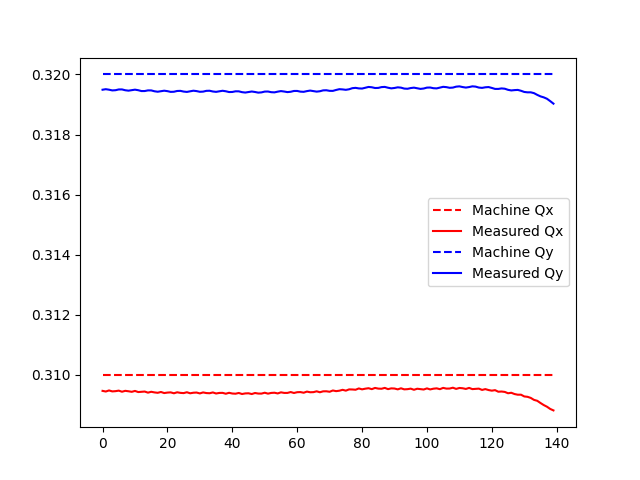

64.31